[(16, 15, 1.0), (17, 13, 2.8284271247461903), (18, 12, 4.242640687119285), (11, 12, 5.0)]


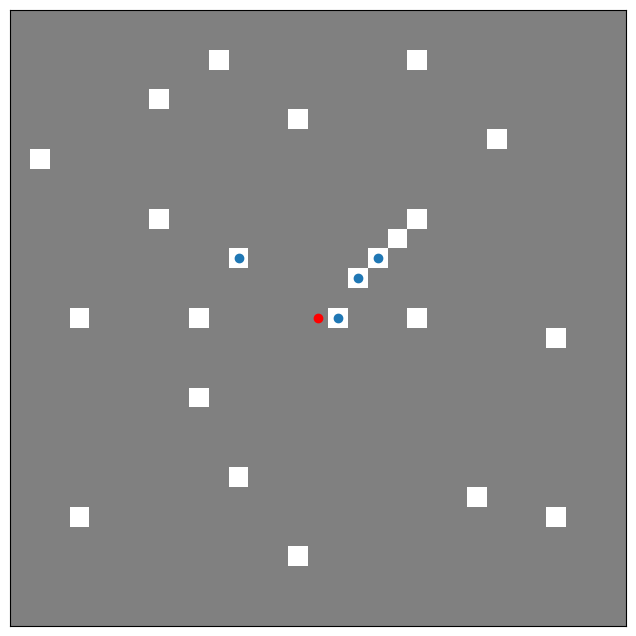

In [7]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy
import numpy as np
import math

defined      = 0
undefined    = 255

mask  = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE )

def find_nearest_neighbors_brute_force( coordinate, mask, k, axis=None, Debug=False ):
    x_origin,y_origin = coordinate
    candidates = []
    for y in range(mask.shape[1]):
        for x in range(mask.shape[0]):
            if x_origin == x and y_origin == y:
                continue
            if mask[y,x] == defined:
                dx = x-x_origin
                dy = y-y_origin
                distance = numpy.sqrt( dx*dx+dy*dy )
                candidates.append( ( x, y, distance ) )
    candidates = sorted( candidates, key=lambda x: x[2] )
    return candidates[0:k]

def display_neightbors( axis, mask, origin, neighbors ):
    axis.imshow(mask, cmap='Greys', alpha=0.5)
    X = [x for x,_,_ in neighbors ]
    Y = [y for _,y,_ in neighbors ]
    ox,oy = origin
    axis.scatter( x=[ox],y=[oy], c="red" )
    axis.scatter( x=X,y=Y )
    axis.set_xticks([])
    axis.set_yticks([])

origin = (15,15)
neighbors = find_nearest_neighbors_brute_force( origin, mask, 4, None, True ) 
print( neighbors )

fig,axis = plt.subplots( 1, 1, figsize=(16,8) )
display_neightbors( axis, mask, origin, neighbors )
plt.savefig("knn_search_brute_force.png")
plt.show()

In [103]:
def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)


def find_nearest_neighbours_quadratic(mask: np.ndarray, origin: tuple[int, int], k: int) -> list[tuple[int, int, float]]:
    origin_y, origin_x = origin
    height, width = mask.shape
    processed = set()
    neighbours = []

    for distance in range(1, mask.shape[0] // 2 + 1):
        pixels_to_process = []
        tl_y, tl_x = max(origin_y - distance, 0), max(origin_x - distance, 0)
        br_y, br_x = min(origin_y + distance, height - 1), min(origin_x + distance, width - 1)

        for y in range(tl_y, br_y + 1):
            if (y, tl_x) not in processed:
                pixels_to_process.append((y, tl_x))
            if (y, br_x) not in processed:
                pixels_to_process.append((y, br_x))

        for x in range(tl_x + 1, br_x):
            if (tl_y, x) not in processed:
                pixels_to_process.append((tl_y, x))
            if (br_y, x) not in processed:
                pixels_to_process.append((br_y, x))

        for y, x in pixels_to_process:
            if mask[y, x] == defined:
                distance = euclidean_distance(origin, (y, x))
                if len(neighbours) < k:
                    neighbours.append((y, x, distance))
                elif len(neighbours) == k and distance < neighbours[-1][2]:
                    neighbours.pop()
                    neighbours.append((y, x, distance))
                neighbours = sorted(neighbours, key=lambda tup: tup[2])
        processed.update(pixels_to_process)

    return neighbours

In [113]:
import unittest

class TestKNN(unittest.TestCase):
    def make_display(self, mask, origin, neighbours):
        fig, axis = plt.subplots( 1, 1, figsize=(16,8) )
        axis.imshow(mask, cmap='Greys', alpha=0.5)
        X = [x for _, x, _ in neighbours ]
        Y = [y for y, _, _ in neighbours ]
        oy,ox = origin
        axis.scatter( x=[ox],y=[oy], c="red" )
        axis.scatter( x=X,y=Y )
        axis.set_xticks([])
        axis.set_yticks([])
        plt.show()

    def test_bruteforce(self):
        neighbors = find_nearest_neighbors_brute_force( origin, mask, 4, None, True )
        neighbors = sorted([(y, x) for y, x, _ in neighbors])
        gt = sorted([(16, 15), (17, 13), (18, 12), (11, 12)])

        self.assertCountEqual(neighbors, gt)

    def test_quadatic(self):
        gt = sorted([(15, 16), (13, 17), (12, 18), (12, 11)])

        neighbors = find_nearest_neighbours_quadratic(mask, origin, 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        self.assertCountEqual(neighbors_, gt)
        # self.make_display(mask, origin, neighbors)

    def test_quadratic_edge(self):
        im = np.array([[255, 255, 255, 255, 0, 255, 255, 255, 255],
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 0], 
               [0, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 0, 255, 255, 255, 255], 
               ])
        gt = sorted([(3, 8), (1, 7), (7, 7), (0, 4)])
        neighbors = find_nearest_neighbours_quadratic(im, (4, 8), 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        self.assertCountEqual(neighbors_, gt)
        # self.make_display(im, (4, 8), neighbors)

    def test_quadratic_middle(self):
        im = np.array([[255, 255, 255, 255, 0, 255, 255, 255, 255],
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 0], 
               [0, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 255, 255, 255, 255, 255, 255, 255, 255], 
               [255, 0, 255, 255, 255, 255, 255, 0, 255], 
               [255, 255, 255, 255, 0, 255, 255, 255, 255], 
               ])
        gt = sorted([(4, 0), (0, 4), (8, 4), (3, 8)])
        neighbors = find_nearest_neighbours_quadratic(im, (4, 4), 4)
        neighbors_ = sorted([(y, x) for y, x, _ in neighbors])

        # self.make_display(im, (4, 4), neighbors)
        self.assertCountEqual(neighbors_, gt)

unittest.main(argv=[""], verbosity=2, exit=False)

test_bruteforce (__main__.TestKNN.test_bruteforce) ... ok
test_quadatic (__main__.TestKNN.test_quadatic) ... ok
test_quadratic_edge (__main__.TestKNN.test_quadratic_edge) ... ok
test_quadratic_middle (__main__.TestKNN.test_quadratic_middle) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


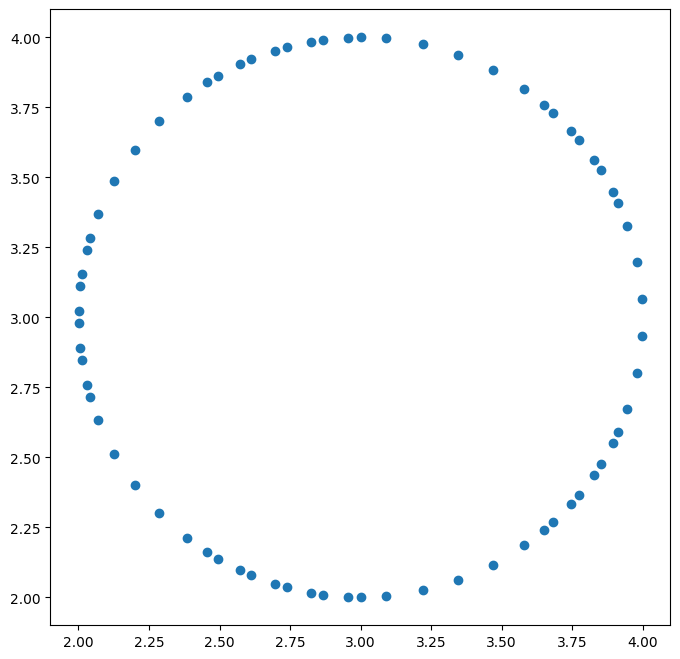

In [124]:
X, Y = [], []
radius = 1
origin_x, origin_y = 3, 3
for theta in range(0, 360, 5):
    X.append(radius * math.sin(theta) + origin_x)
    Y.append(radius * math.cos(theta) + origin_y)
fig, axis = plt.subplots( 1, 1, figsize=(8,8) )    
axis.scatter( x=X,y=Y )
plt.show()

In [122]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]